In [189]:
from collections import Counter
from tqdm import tqdm
import cgranges
import pandas as pd

In [4]:
class Isoform:
    def __init__(self, tid, chrom, strand):
        self.tid = tid
        self.chrom = chrom
        self.strand = strand
        self.exons = list()
    def build_introns(self):
        self.introns = tuple(
            (e1+1, s2-1)
            for (_,e1),(s2,_) in zip(self.exons[:-1], self.exons[1:])
        )
    def build_intron_str(self):
        self.introns_str = ":".join([f"{x[0]}-{x[1]}" for x in self.introns])

In [5]:
def get_isoforms(in_gtf):
    bad_tids = set()
    isoforms = list()
    tid_to_idx = dict()
    for line in tqdm(open(in_gtf), desc=f"Reading {in_gtf}"):
        if line.startswith('#'):
            continue
        line = line.strip().split('\t')
        if line[2] != 'exon':
            continue

        info = line[8]
        info = [x.strip().split(' ') for x in info.strip(';').split(';')]
        info = {x[0]:x[1].strip('"') for x in info}

        tid = info['transcript_id']
        if tid not in tid_to_idx:
            tid_to_idx[tid] = len(isoforms)
            isoforms.append(Isoform(
                tid=tid,
                chrom=line[0],
                strand=line[6],
            ))
        idx = tid_to_idx[tid]
        start, end = int(line[3]) - 1, int(line[4])
        if end - start < 1:
            bad_tids.add(tid)
        isoforms[idx].exons.append((start, end))
    for isoform in isoforms:
        isoform.exons = tuple(sorted(isoform.exons))
        isoform.build_introns()
        isoform.build_intron_str()
    print(f"Found {len(bad_tids)} transcripts with bad coordinates")
    print(bad_tids)
    isoforms = [x for x in isoforms if x.tid not in bad_tids]
    tid_to_idx = {x.tid:i for i,x in enumerate(isoforms)}
    return tid_to_idx,isoforms

In [6]:
in_gtf = "output/results/S1/freddie.isoforms.gtf"
annot_gtf = "data/refs/homo_sapiens.annot.gtf"
in_tid_to_idx,in_isoforms = get_isoforms(in_gtf)
annot_tid_to_idx,annot_isoforms = get_isoforms(annot_gtf)

Reading output/results/S1/freddie.isoforms.gtf: 396880it [00:02, 192309.22it/s]


Found 5 transcripts with bad coordinates
{'2_49_0', '19_450_0', '15_247_0', '12_77_5', '10_489_1'}


Reading data/refs/homo_sapiens.annot.gtf: 3408735it [00:25, 131770.00it/s]


Found 0 transcripts with bad coordinates
set()


In [7]:
def get_index(isoforms):
    I = cgranges.cgranges()
    for idx, isoform in tqdm(enumerate(isoforms), total=len(isoforms)):
        for s,e in isoform.exons:
            I.add(isoform.chrom, s, e, idx)
    I.index()
    return I

In [8]:

def get_canonical_intervals(interval_lists, min_length=0):
    result = list()
    breakpoints = set()
    g = cgranges.cgranges()
    for idx, genomic_interval_list in enumerate(interval_lists):
        for start, end in genomic_interval_list:
            g.add("", start, end, idx)
            breakpoints.add(start)
            breakpoints.add(end)
    g.index()
    breakpoints = sorted(breakpoints)
    for s,e in zip(breakpoints[:-1], breakpoints[1:]):
        if e - s < min_length:
            continue
        labels = set((l for _,_,l in g.overlap("", s, e)))
        labels = tuple(idx in labels for idx in range(len(interval_lists)))
        if any(labels):
            result.append((s, e, labels))
    return result

In [62]:
def charecterize_intervals(c_intervals):
    i = j = -1
    for i,(_,_,labels) in enumerate(c_intervals):
        if all(labels):
            break
    for j,(_,_,labels) in enumerate(c_intervals[::-1]):
        if all(labels):
            break
    assert i != -1, c_intervals
    j = len(c_intervals) - j - 1

    counter = Counter()
    for idx, (_,_,labels) in enumerate(c_intervals):
        if idx < i:
            key = -1 # Prefix
        elif idx > j: 
            key = +1 # Suffix
        else:
            key = 0 # Main
        counter[(key, *labels)] += 1
    return counter


In [10]:
annot_exon_index = get_index(annot_isoforms)
in_exon_index = get_index(in_isoforms)

  0%|          | 0/252242 [00:00<?, ?it/s]

100%|██████████| 72295/72295 [00:00<00:00, 431990.67it/s]


In [51]:
matches[(-1, False, True)]

2

In [122]:
fields = [
    "in_iso",
    "annot_iso",
    "in_exons",
    "annot_exons",
    "in_c_exons",
    "annot_c_exons",
    "prefix_m",
    "prefix_i",
    "prefix_d",
    "main_m",
    "main_i",
    "main_d",
    "suffix_m",
    "suffix_i",
    "suffix_d",
]
match_fields_keys = [
    (-1, True, True),
    (-1, False, True),
    (-1, True, False),
    (0, True, True),
    (0, False, True),
    (0, True, False),
    (+1, True, True),
    (+1, False, True),
    (+1, True, False),    
]
X = 0
with open("isoform-matches.csv", "w+") as outfile:
    record = list()
    for f in fields:
        record.append(f"{f}")
    print(",".join(record), file=outfile)
    i_isoforms_tids = set()
    a_isoforms_tids = set()
    for i_isoform in tqdm(in_isoforms):
        a_idxs = {
            a_idx
            for s,e in i_isoform.exons
            for _,_,a_idx in annot_exon_index.overlap(i_isoform.chrom, s, e)
        }
        for a_idx in a_idxs:
            record = [
                f"{i_isoform.tid}",
                f"{annot_isoforms[a_idx].tid}",
                f"{len(i_isoform.exons)}",
                f"{len(annot_isoforms[a_idx].exons)}",
            ]       

            c_intervals = get_canonical_intervals(
                (
                    annot_isoforms[a_idx].exons,
                    i_isoform.exons,
                ),
                min_length=5
            )
            matches = charecterize_intervals(c_intervals)
            record.extend([
                f"{sum(v for k,v in matches.items() if k[2])}", # Canonical intervals with input isoform
                f"{sum(v for k,v in matches.items() if k[1])}", # Canonical intervals with annot isoform
            ])
            i_isoforms_tids.add(i_isoform.tid)
            a_isoforms_tids.add(annot_isoforms[a_idx].tid)
            for key in match_fields_keys:
                record.append(f"{matches[key]}")
            print(",".join(record), file=outfile)
            X += 1


100%|██████████| 72295/72295 [00:57<00:00, 1267.94it/s]


In [117]:
X

711132

In [123]:
A = pd.read_csv("isoform-matches.csv")

In [ ]:
B = pd.read_csv("output/simulate/TS/S1.tsv", sep='\t')

In [181]:
min_coverage = 10
tid_to_counts = B.transcript_id.value_counts()
simulated_tids = tid_to_counts[tid_to_counts > min_coverage]

In [188]:
detected_tids = set(A[
    (A.main_m == A.in_c_exons)
    & (A.annot_c_exons - A.main_m < 3)
].annot_iso)

In [197]:
coverage = list()
detection = list()
detected_count = 0
for tid, count in simulated_tids.items():
    coverage.append(count)
    detected_count += tid in detected_tids
    detection.append(detected_count)

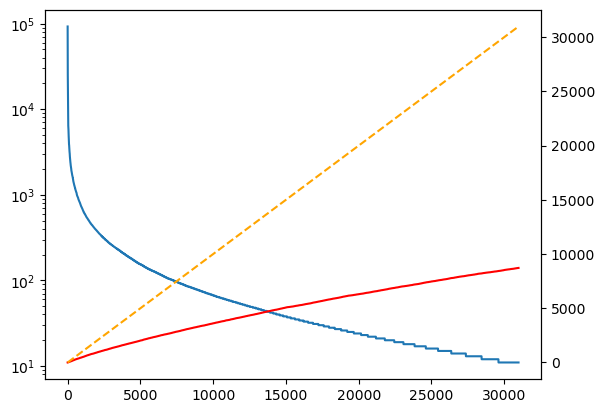

In [204]:
fig, ax = plt.subplots()
ax.plot(coverage)
# Make log scale
ax.set_yscale('log')
# Twin axis
ax2 = ax.twinx()
ax2.plot(detection, color='red')
ax2.plot([0, len(coverage)], [0, len(coverage)], linestyle='--', color='orange')